In [1]:
import matplotlib.cm
import numpy as np
from scipy import integrate

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.pylab as pylab

import pandas as pd

from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                   mark_inset)

import matplotlib.image as mpimg
import matplotlib.pylab as pylab

from scipy.stats import halfnorm
from scipy.spatial import distance_matrix,distance

import re
import os 
import subprocess

%matplotlib inline


/Users/gabrieletocci/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  # This is added back by InteractiveShellApp.init_path()


## Define constants and other parameters

In [2]:


#slip lengths from Tocci et al. 2020, 12, 10994-11000
bGra = 19.6;
bBN = 4.0;

#conversion factors between energy scales
kjmol2eV=0.010364272
har2eV=27.211386246
kBTeV = 0.02585

#convert molar concentration to nm^{-3}
mol2invnmcube = 0.6022;

#convert electron charge^2/(4*pi* vacuum permittivity)  to eV*nanometers
#this results into elementary_charge_sq_div_epszero
epsr=78.0
elementary_charge_sq_div_epszero = 1.439964548
bjerrum_length = elementary_charge_sq_div_epszero/kBTeV/epsr

#viscosity of water in N*s/m^2
visc_water = 0.89*10**-3

#z_tilde is used in the ESC model and is defined in the SI
z_tilde = 0.33


In [3]:
dir_integrals="mPB_integrals"

dir_integrals_gra_short="mPB_integrals_graishort"

dir_integrals_epsilon="mPB_integrals_eps"

dir_data='data_preprocessed'

dir_figures='figures_paper'


## Import raw AIMD free energy data for figure 2 in the main text

In [4]:
def get_free_energy(free_ener_file):
    '''Extract the free energy and error versus height from raw data files obtained from Umbrella integration.
       The free energy is in kjmol and height is in nanometers
    '''

    bulk_region = [0.98,1.52]
    free_energy_data = np.loadtxt(free_ener_file)
    idx_bulk = (free_energy_data[:,0] > bulk_region[0]) & (free_energy_data[:,0] <bulk_region[1])
    idx_interface = np.where(free_energy_data[:,0] < bulk_region[1])[0]
    free_energy_data[:,1] -= np.mean(free_energy_data[idx_bulk,1])

    height_from_surf=free_energy_data[idx_interface,0]
    free_energy=free_energy_data[idx_interface,1]
    free_energy_error=free_energy_data[idx_interface,2]
    
    return height_from_surf,free_energy,free_energy_error

In [5]:
#the free energies are computed from umbrella integration and are in kjmol, heights are in nm

height_GRAI, DG_GRAI, err_GRAI = get_free_energy(dir_data+"/FreeEnergyGraI.dat")
height_GRAK, DG_GRAK, err_GRAK = get_free_energy(dir_data+"/FreeEnergyGraK.dat")
height_BNI, DG_BNI, err_BNI = get_free_energy(dir_data+"/FreeEnergyBNI.dat")
height_BNK, DG_BNK, err_BNK = get_free_energy(dir_data+"/FreeEnergyBNK.dat")


## Import re-weighted mass density and dipole orientation profiles from aimd data

In [6]:
#mass density in g/cm^3 re-weighted with WHAM

dens_gra  = np.loadtxt(dir_data+'/water_density_graphene.dat')
dens_hBN  = np.loadtxt(dir_data+'/water_density_hBN.dat')

#cosine of water dipole orientation times water density
dip_gra  = np.loadtxt(dir_data+'/water_dipole_graphene.dat')
dip_hBN  = np.loadtxt(dir_data+'/water_dipole_hBN.dat')

#cosine of water dipole orientation times water density
prob_dip_gra  = np.loadtxt(dir_data+'/water_prob_dipole_graphene.dat')
prob_dip_hBN  = np.loadtxt(dir_data+'/water_prob_dipole_hbn.dat')


In [7]:
FGRAI = np.loadtxt(dir_data+"/FreeEnergyGraI.dat")

idx_bulk = (FGRAI[:,0] > 0.98) & (FGRAI[:,0] <1.52)

idx_interface = np.where(FGRAI[:,0] < 1.52)[0]

FGRAI[:,1] -= np.mean(FGRAI[idx_bulk,1])

x_GI70=FGRAI[idx_interface,0]
y_GI70=FGRAI[idx_interface,1]
err_GI70=FGRAI[idx_interface,2]



### Import transport coefficients from post-processing in mathematica as a function of concentration
* Column 0 is the concentration in M
* Column 1 is the zeta-potential already in V
* Column 2 is the integral of the diffusio-osmotic transport coefficient in nm$^{-1}$:
 $$ \int_0^\infty \left(n_+(z)+n_-(z) -2 n_s^\infty \frac{n_w(z)}{n_w^\infty} \right) \times (z+b) dz$$
* Column 3 is the integral of the diffusio-osmotic conductivity in nm$^{-3}$:
 $$(4\pi l_B)^{-1} \int_0^\infty  \left(n_+(z)+n_-(z) -2 n_s^\infty \frac{n_w(z)}{n_w^\infty} \right)  \times (\phi(z) - \phi_s) dz$$

In [8]:
#get transport coefficients from postprocessing in mathematica
#Column 0 is concentration
#Column 1 is zeta-potential already in V
#Column 2 is the integral of the diffusio-osmotic transport coefficient in nm^-1
#Column 3 is the integral of the diffusio-osmotic conductivity in nm^{-3} 

Transport_Coeffs_GRA_SHORT=np.loadtxt(dir_integrals_gra_short+"/Transport_Coeffs_Gra.dat")
Transport_Coeffs_GRA=np.loadtxt(dir_integrals+"/Transport_Coeffs_Gra.dat")
Transport_Coeffs_BN=np.loadtxt(dir_integrals+"/Transport_Coeffs_BN.dat")

#get transport coefficients with a step-polarization model of the dielectric constant
#from postprocessing in mathematica
Transport_Coeffs_GRA_eps=np.loadtxt(dir_integrals_epsilon+"/Transport_Coeffs_Gra.dat")
Transport_Coeffs_BN_eps=np.loadtxt(dir_integrals_epsilon+"/Transport_Coeffs_BN.dat")

#concentration in M is the first column in the transport coefficient data   
Conc = Transport_Coeffs_GRA[:,0]
#concentration in nm^{-3}
Conc_invcbnm = Conc*mol2invnmcube
Zeta_GRA=Transport_Coeffs_GRA[:,1]
Integral_DO_GRA=Transport_Coeffs_GRA[:,2]
Integral_KOSM_GRA=Transport_Coeffs_GRA[:,3]

Zeta_BN=Transport_Coeffs_BN[:,1]
Integral_DO_BN=Transport_Coeffs_BN[:,2]
Integral_KOSM_BN=Transport_Coeffs_BN[:,3]

#calculate the debye length from the bjerrum length and salt concentration
debye_length = 1.0/np.sqrt(8*np.pi*bjerrum_length*Conc_invcbnm)
Conc_lin = np.arange(1.1,6,0.1)
Conc_large=np.append(Conc[:-5],Conc_lin)
Conc_large_invcbnm=Conc_large*mol2invnmcube
debye_length_lin = 1.0/np.sqrt(8*np.pi*bjerrum_length*Conc_large_invcbnm)


### Import charge density profile, solute density profiles, electrostatic potential profiles computed from mathematica for different salt concentrations

In [9]:

#get rho_e(z) from post-processing in mathematica
charge_diff_GRA=np.loadtxt(dir_integrals+"/RhoeGRAConc.dat")
charge_diff_BN=np.loadtxt(dir_integrals+"/RhoeBNConc.dat")

#get electrostatic potential from post-processing in mathematica
V_poiss_GRA=np.loadtxt(dir_integrals+"/PoissonPotGRAConc.dat")
V_poiss_BN=np.loadtxt(dir_integrals+"/PoissonPotBNConc.dat")

#get n_+(z) + n_-(z) -2*n_s^\inf*(n_w(z)/n_w^\inf) from post-processing in mathematica
SoluteWatProfGraConc=np.loadtxt(dir_integrals+"/SoluteWatProfileGraConc.dat")
SoluteWatProfBNConc=np.loadtxt(dir_integrals+"/SoluteWatProfileBNConc.dat")

#get number density of water from postprocessing in mathematica
WatGRAConc=np.loadtxt(dir_integrals+"/IntegratedWatDensGra.dat")[:,1]
WatBNConc=np.loadtxt(dir_integrals+"/IntegratedWatDensBN.dat")[:,1]


#get free energies in eV this time from post-processing in mathematica
free_energy_long=np.loadtxt(dir_integrals+"/FreeEnergy_gra_bn_ik.dat")
#get free energies in eV this time from post-processing in mathematica,
#where the free energy for I$^-$ on graphene is actually computed over the first 30 ps instead of the full 60 ps
free_energy_short=np.loadtxt(dir_integrals_gra_short+"/FreeEnergy_gra_bn_ik.dat")

height_long=free_energy_long[:,0]
FGRAI=free_energy_long[:,1]
FGRAI_SHORT = free_energy_short[:,1]
FGRAK=free_energy_long[:,2]
FBNI=free_energy_long[:,3]
FBNK=free_energy_long[:,4]

#get anion and cation number densities (i.e. n_+(z) and n_-(z))
RhoGraK=np.loadtxt(dir_integrals+"/RhoGraConcCat.dat")
RhoGraI=np.loadtxt(dir_integrals+"/RhoGraConcAn.dat")
RhoBNK=np.loadtxt(dir_integrals+"/RhoBNConcCat.dat")
RhoBNI=np.loadtxt(dir_integrals+"/RhoBNConcAn.dat")

#get n_+(z) + n_-(z) -2*n_s^\inf*(n_w(z)/n_w^\inf) from post-processing in mathematica
SoluteGra=np.loadtxt(dir_integrals+"/SoluteProfileGraConc.dat")
SoluteBN=np.loadtxt(dir_integrals+"/SoluteProfileBNConc.dat")
    
#get the grid size for numerical integrations
dz = height_long[1]-height_long[0]


### Convert the integral of the diffusio-osmotic coefficient into $D_{DO}$, which has the units of a diffusion coefficient. 

* "Integral_DO" is in nm$^{-1}$, the viscosity of water ($\eta$) is in  (N$\cdot$s)/m$^2$, $k_BT$ is in $eV$. 
* $D_{DO} = \textrm{Integral_DO} \times k_BT / \eta$
* The conversion from wolframalpha is "convert electronvolt/nanometers/(Newton*second/meters^2) to micrometers^2/second"


In [10]:

prefactor_ddo = 160.2
conv_fact_ddo = kBTeV/visc_water*prefactor_ddo

DDO_GRA=Integral_DO_GRA*conv_fact_ddo
DDO_GRA_SHORT=Transport_Coeffs_GRA_SHORT[:,2]*conv_fact_ddo

DDO_BN=Transport_Coeffs_BN[:,2]*conv_fact_ddo
DDO_GRA_eps=Transport_Coeffs_GRA_eps[:,2]*conv_fact_ddo
DDO_BN_eps=Transport_Coeffs_BN_eps[:,2]*conv_fact_ddo

#We also compute the electro-osmotic contribution to the diffusio-osmotic coefficient
# bulk_diff_ratio is 2% for iodide, see SI.
# and we get the conversion factor also from mathematica as: 
# convert elementary charge * volt/(pascal*second*nanometer) to micrometer^2/second
# formula for K_do_eo (see SI) is K_do_eo = -e*zeta/(4pi eta lB)

bulk_diff_ratio = 0.02

KDO_EO_GRA = -Zeta_GRA* bulk_diff_ratio*conv_fact_ddo/(4*np.pi*visc_water*bjerrum_length)
KDO_EO_BN = -Zeta_BN* bulk_diff_ratio*conv_fact_ddo/(4*np.pi*visc_water*bjerrum_length)


### Convert the integral of the diffusio-osmotic coefficient into  $K_{osm}$ , which has the units of nanometers.

* "Integral_Kosm" is in nm$^{−3}$ , the viscosity of water ( 𝜂 ) is in (N ⋅ s)/m$^2$ ,  $𝑘_𝐵𝑇$  is in  𝑒𝑉. 

* $K_{osm}=\textrm{Integral_Kosm}×𝑘_𝐵𝑇/𝜂 $

* The conversion from wolframalpha is "convert elementary charge * eV/ (N*s/m^2) * nm^-3 to nanoAmpere"

In [11]:

prefactor_kosm = 0.02567
conv_fact_kosm=prefactor_kosm*kBTeV/visc_water

K_osm_GRA = conv_fact_kosm * Transport_Coeffs_GRA[:,3]
K_osm_GRA_SHORT = conv_fact_kosm * Transport_Coeffs_GRA_SHORT[:,3]
K_osm_BN = conv_fact_kosm * Transport_Coeffs_BN[:,3]

K_osm_GRA_eps = conv_fact_kosm * Transport_Coeffs_GRA_eps[:,3]
K_osm_BN_eps = conv_fact_kosm * Transport_Coeffs_BN_eps[:,3]


### Get characteristic lengths for the ESC model

In [12]:
def get_adsorption_lengths(profile,height,dz,profile_type="free_energy"):

    if profile_type == "free_energy":
        K = dz*np.trapz( np.exp(-profile) -1)
        L = dz*np.trapz((height)* (np.exp(-profile) -1))/K
        return K,L

    elif profile_type == "density":
        K = dz*np.trapz(profile -1.)
        L = dz*np.trapz(height*(profile -1.))/K
        return K,L
    else:
        raise ValueError("profile_type can only be \"free_energy\" or \"density\" ") 

def get_adsorption_lengths_tilde(profile,height,dz,z_tilde,profile_type = "free_energy"):

    if profile_type == "free_energy":

        z_idx = int(np.rint(z_tilde/dz))
        K = dz*np.trapz( (np.exp(-profile[z_idx:]) -1))
        L = dz*np.trapz((height[z_idx:])* (np.exp(-profile[z_idx:]) -1))/K -z_tilde
        return K,L
    
    elif profile_type == "density":
        
        z_idx = int(np.rint(z_tilde/dz))
        K = dz*np.trapz((profile[z_idx:] -1.))
        L = dz*np.trapz((height[z_idx:])*(profile[z_idx:] -1.))/K -z_tilde
        return K,L
        
    else:
        raise ValueError("profile_type can only be \"free_energy\" or \"density\" ") 
    

In [13]:
K_p_Gra, L_p_Gra = get_adsorption_lengths(FGRAK/kBTeV,height_long,dz)
K_m_Gra, L_m_Gra = get_adsorption_lengths(FGRAI/kBTeV,height_long,dz)

K_p_BN, L_p_BN = get_adsorption_lengths(FBNK/kBTeV,height_long,dz)
K_m_BN, L_m_BN = get_adsorption_lengths(FBNI/kBTeV,height_long,dz)

KT_p_Gra, LT_p_Gra = get_adsorption_lengths_tilde(FGRAK/kBTeV,height_long,dz,z_tilde)
KT_m_Gra, LT_m_Gra = get_adsorption_lengths_tilde(FGRAI/kBTeV,height_long,dz,z_tilde)

KT_p_BN, LT_p_BN = get_adsorption_lengths_tilde(FBNK/kBTeV,height_long,dz,z_tilde)
KT_m_BN, LT_m_BN = get_adsorption_lengths_tilde(FBNI/kBTeV,height_long,dz,z_tilde)

K_w_Gra, L_w_Gra = get_adsorption_lengths(WatGRAConc/WatGRAConc[-1],height_long,dz,profile_type="density")
K_w_BN, L_w_BN = get_adsorption_lengths(WatBNConc/WatBNConc[-1],height_long,dz,profile_type="density")

KT_w_Gra, LT_w_Gra = get_adsorption_lengths_tilde(WatGRAConc/WatGRAConc[-1],height_long,dz,z_tilde,profile_type="density")
KT_w_BN, LT_w_BN = get_adsorption_lengths_tilde(WatBNConc/WatBNConc[-1],height_long,dz,z_tilde,profile_type="density")



In [14]:
df_lengths = pd.DataFrame([["graphene",'%1.3f' % K_p_Gra,'%1.3f' %K_m_Gra,'%1.3f' %K_w_Gra,'%1.3f' %L_p_Gra,'%1.3f' %L_m_Gra,'%1.3f' %L_w_Gra],
                   ["hBN",'%1.3f' %K_p_BN,'%1.3f' %K_m_BN,'%1.3f' %K_w_BN,'%1.3f' %L_p_BN,'%1.3f' %L_m_BN,'%1.3f' %L_w_BN]],
                  columns=["lengths [nm] ",r"$K_+$",r"$K_-$",r"$K_w$",r"$L_+$",r"$L_-$",r"$L_w$"])

df_lengths

lengths [nm]    $K_+$  $K_-$   $K_w$   $L_+$  $L_-$   $L_w$
0      graphene  -0.229  1.974  -0.179  -0.363  0.460   0.031
1           hBN  -0.207  0.177  -0.165  -0.442  0.100  -0.027

In [15]:
df_lengths_tilde = pd.DataFrame([["graphene",'%1.3f' % KT_p_Gra,'%1.3f' %KT_m_Gra,'%1.3f' %KT_w_Gra,'%1.3f' %LT_p_Gra,'%1.3f' %LT_m_Gra,'%1.3f' %LT_w_Gra],
                   ["hBN",'%1.3f' %KT_p_BN,'%1.3f' %KT_m_BN,'%1.3f' %KT_w_BN,'%1.3f' %LT_p_BN,'%1.3f' %LT_m_BN,'%1.3f' %LT_w_BN]],
                  columns=["lengths-tilde [nm] ",r"$\tilde{K}_+$",r"$\tilde{K}_-$",r"$\tilde{K}_w$",r"$\tilde{L}_+$",r"$\tilde{L}_-$",r"$\tilde{L}_w$"])

df_lengths_tilde

lengths-tilde [nm]  $\tilde{K}_+$ $\tilde{K}_-$ $\tilde{K}_w$ $\tilde{L}_+$  \
0            graphene         0.086         2.067         0.013         1.228   
1                 hBN         0.107         0.375         0.020         0.990   

  $\tilde{L}_-$ $\tilde{L}_w$  
0         0.100         0.223  
1        -0.249         0.424

### Get transport coefficients according to the ESC model

In [16]:
def get_zeta_esc(K_p,L_p,K_m,L_m,debye_length,scale_factor):
    
    '''give ion adsorption lengths, debye_length and scale factor
    as input and return the zeta-potential.'''
        
    zeta_esc = scale_factor*(K_p-K_m)/(2*debye_length + K_p + K_m)
    return zeta_esc


def get_eff_surf_charge(Conc,phi_s,K_p,K_m,bjerrum_length):
    '''give concentration (in nm^-3), dimensionless surface potential and K-lengths 
    and return the effective surface charge and gouy chapman length'''
    
    sigma_eff = Conc*(K_p*np.exp(- phi_s ) -K_m*np.exp( phi_s ))    
    l_GC_eff = 1/(2.0*np.pi*bjerrum_length*np.abs(sigma_eff)  )
    
    return sigma_eff, l_GC_eff


def get_DDO_esc(K_p,L_p,K_m,L_m,K_w,L_w,phi_s,debye_length,
               l_GC_eff, bjerrum_length,b,conv_fact):
    
    
    gamma = np.tanh(phi_s/4)
    PB_term = -np.log(1- gamma**2)
    
    I_p = K_p*np.exp(- phi_s )
    I_m = K_m*np.exp( phi_s )

    KL_term = (I_p*L_p + I_m*L_m -2*K_w*L_w)/(4*debye_length**2)

    slip_term_ads = (b/debye_length)*(  (I_p + I_m -2*K_w)/(4*debye_length)  )
    slip_term_PB = (b/debye_length)*( np.abs(gamma)*debye_length/l_GC_eff )

    DDO_PB = PB_term*conv_fact/(np.pi*2*bjerrum_length)
    DDO_slip_ads = slip_term_ads*conv_fact/(np.pi*2*bjerrum_length)
    DDO_slip_PB = slip_term_PB*conv_fact/(np.pi*2*bjerrum_length)
    DDO_KL = KL_term*conv_fact/(np.pi*2*bjerrum_length)
    
    DDO_esc = DDO_PB + DDO_slip_PB + DDO_KL + DDO_slip_ads
    
    return DDO_esc, DDO_slip_ads, DDO_slip_PB, DDO_KL


def get_Kosm_esc(K_p,L_p,K_m,L_m,K_w,L_w,phi_s,debye_length,
                 sigma_eff, l_GC_eff, bjerrum_length,conv_fact):
    
    I_p = K_p*np.exp(- phi_s )
    I_m = K_m*np.exp( phi_s )

    Chi =  debye_length/l_GC_eff
    Kosm_PB = conv_fact*sigma_eff*( 1 - np.arcsinh(Chi)/Chi )
    Kosm_ads = conv_fact*sigma_eff*(I_p*L_p + I_m*L_m -2*K_w*L_w)/(4*debye_length**2)
    
    Kosm_esc = Kosm_PB + Kosm_ads
    
    return Kosm_esc, Kosm_ads, Kosm_PB



In [17]:
zeta_Gra_esc = get_zeta_esc(K_p_Gra,L_p_Gra,K_m_Gra,L_m_Gra,debye_length_lin,kBTeV)
zeta_BN_esc = get_zeta_esc(K_p_BN,L_p_BN,K_m_BN,L_m_BN,debye_length_lin,kBTeV)

phi_s_Gra=zeta_Gra_esc/kBTeV
phi_s_BN=zeta_BN_esc/kBTeV

sigma_Gra, l_GC_eff_Gra  = get_eff_surf_charge(Conc_large_invcbnm,phi_s_Gra,K_p_Gra,K_m_Gra,bjerrum_length)
sigma_BN, l_GC_eff_BN = get_eff_surf_charge(Conc_large_invcbnm,phi_s_BN,K_p_BN,K_m_BN,bjerrum_length)


DDO_Gra_esc,DDO_slip_ads_Gra, DDO_slip_PB_Gra,DDO_KL_Gra = get_DDO_esc(K_p_Gra,L_p_Gra,K_m_Gra,L_m_Gra,K_w_Gra,L_w_Gra,
                                                            phi_s_Gra,debye_length_lin, l_GC_eff_Gra, 
                                                            bjerrum_length,bGra,conv_fact_ddo)

DDO_BN_esc,DDO_slip_ads_BN, DDO_slip_PB_BN,DDO_KL_BN = get_DDO_esc(K_p_BN,L_p_BN,K_m_BN,L_m_BN,K_w_BN,L_w_BN,
                                                        phi_s_BN,debye_length_lin,l_GC_eff_BN,
                                                        bjerrum_length,bBN,conv_fact_ddo)


conv_fact_kosm_esc = -prefactor_kosm*kBTeV/visc_water/(2*np.pi)/bjerrum_length

K_osm_Gra_esc, K_osm_Gra_ads, K_osm_Gra_PB = get_Kosm_esc(KT_p_Gra,LT_p_Gra,KT_m_Gra,LT_m_Gra,KT_w_Gra,LT_w_Gra,
                                                       phi_s_Gra,debye_length_lin, sigma_Gra, l_GC_eff_Gra, 
                                                       bjerrum_length,conv_fact_kosm_esc)

K_osm_BN_esc, K_osm_BN_ads, K_osm_BN_PB = get_Kosm_esc(KT_p_BN,LT_p_BN,KT_m_BN,LT_m_BN,KT_w_BN,LT_w_BN,
                                                    phi_s_BN,debye_length_lin, sigma_BN, l_GC_eff_BN, 
                                                    bjerrum_length,conv_fact_kosm_esc)

### Numerical calculation of K_osm from a decomposition into a PB-term and into an adsorption term

In [18]:
z_vals = height_long

Integral_DGplus_Gra = dz*np.array([np.trapz((V_poiss_GRA[:,i+1]-V_poiss_GRA[0,i+1])/kBTeV* np.exp(-V_poiss_GRA[:,i+1]/kBTeV) *(np.exp(-FGRAK/kBTeV) -1)) for i in range(len(debye_length)) ])
Integral_DGminus_Gra = dz*np.array([np.trapz((V_poiss_GRA[:,i+1]-V_poiss_GRA[0,i+1])/kBTeV* np.exp(V_poiss_GRA[:,i+1]/kBTeV) * (np.exp(-FGRAI/kBTeV) -1)) for i in range(len(debye_length)) ])

Integral_DGplus_BN = dz*np.array([np.trapz((V_poiss_BN[:,i+1]-V_poiss_BN[0,i+1])/kBTeV* np.exp(-V_poiss_BN[:,i+1]/kBTeV) *(np.exp(-FBNK/kBTeV) -1)) for i in range(len(debye_length)) ])
Integral_DGminus_BN = dz*np.array([np.trapz((V_poiss_BN[:,i+1]-V_poiss_BN[0,i+1])/kBTeV* np.exp(V_poiss_BN[:,i+1]/kBTeV) *(np.exp(-FBNI/kBTeV) -1)) for i in range(len(debye_length)) ])

Integral_w_Gra = dz*np.array([np.trapz((V_poiss_GRA[:,i+1]-V_poiss_GRA[0,i+1])/kBTeV*(WatGRAConc/WatGRAConc[-1] -1.)) for i in range(len(debye_length)) ])
Integral_w_BN = dz*np.array([np.trapz((V_poiss_BN[:,i+1]-V_poiss_BN[0,i+1])/kBTeV*(WatBNConc/WatBNConc[-1] -1.)) for i in range(len(debye_length)) ])

Integral_PB_Gra = dz*np.array([np.trapz( (V_poiss_GRA[:,i+1]-V_poiss_GRA[0,i+1])/kBTeV* Conc_invcbnm[i]*( np.exp(-V_poiss_GRA[:,i+1]/kBTeV) + np.exp(+V_poiss_GRA[:,i+1]/kBTeV) - 2*np.ones(len(z_vals)) ))  for i in range(len(debye_length)) ]) 
Integral_PB_BN = dz*np.array([np.trapz(  (V_poiss_BN[:,i+1]-V_poiss_BN[0,i+1])/kBTeV* Conc_invcbnm[i]*( np.exp(-V_poiss_BN[:,i+1]/kBTeV) + np.exp(+V_poiss_BN[:,i+1]/kBTeV) - 2*np.ones(len(z_vals)) ))  for i in range(len(debye_length)) ]) 

K_osm_ads_Gra_full = 0.5*conv_fact_kosm *(  (Integral_DGplus_Gra +Integral_DGminus_Gra -2*Integral_w_Gra)*Conc_invcbnm)
K_osm_ads_BN_full = 0.5*conv_fact_kosm *(  (Integral_DGplus_BN +Integral_DGminus_BN -2*Integral_w_BN)*Conc_invcbnm )

K_osm_PB_Gra_full = 0.5*conv_fact_kosm *( Integral_PB_Gra )
K_osm_PB_BN_full = 0.5*conv_fact_kosm *( Integral_PB_BN )



### Define quantities to draw the flow profiles

In [19]:

Length=190

size_Arr = 190
slope=3.0

y0=1.25
y1=3.25
x0=0.15
y2=4.04
y3=5.05

sigma_ions = 3.0

y = np.ones(Length)
x = np.array(np.arange(0,Length))/(size_Arr)
x=np.array([0.0])
x=np.append(x,np.geomspace(0.1/slope,0.999/slope,num=Length))

yprime = np.ones(int(Length/10))
xprime = np.array(np.arange(0,Length,10))/(size_Arr)

flow_col = "teal"
Nions=12

while True:
    ryp=np.array(np.random.normal(loc=y0+1.5,scale=1.4,size=int(Nions*1/3))) 
    ryp=np.append(ryp,np.array(np.random.normal(loc=y0+3.,scale=1.4,size=int(Nions*1/3))) )
    ryp=np.append(ryp,np.array(np.random.normal(loc=y0+2.,scale=1.4,size=int(Nions*1/3))) )

    rxp=np.linspace(0.1,0.9,num=Nions)+(np.random.rand(Nions)-0.5)*0.05    
    np.random.shuffle(rxp)
    np.random.shuffle(ryp)
    
    rym0=np.array(np.random.normal(loc=y0+0.25,scale=.012,size=int(Nions*1/3)))
    rym1 = np.array(np.random.normal(loc=y0+2.8,scale=.9,size=int(Nions*2/3)))
    np.random.shuffle(rym1)

    rym = np.append(rym0,rym1)
    
    rxm0=np.linspace(0.05,0.9,num= int(Nions/3)  )+(np.random.rand(int(Nions/3))-0.5)*0.02 
    rxm1=np.linspace(0.05,0.9,num= int(Nions*2/3)  )+(np.random.rand(int(Nions*2/3))-0.5)*0.02 
    np.random.shuffle(rxm1)                        
    rxm=np.append(rxm0,rxm1)
    
    coords = np.array([rxp,ryp]).reshape(2,-1).T
    coords_min = np.array([rxm,rym]).reshape(2,-1).T
    dist_mat_p = distance.cdist(coords, coords, 'euclidean')
    dist_mat_m = distance.cdist(coords_min, coords_min, 'euclidean')
    dist_mat_mp = distance.cdist(coords_min, coords, 'euclidean')

    truth_vals_p = dist_mat_p[dist_mat_p.nonzero()] > 0.1
    truth_vals_m = dist_mat_m[dist_mat_m.nonzero()] > 0.05   
    truth_vals_mp = dist_mat_mp[dist_mat_mp.nonzero()] > 0.2

    len_mat_p = len(dist_mat_p[dist_mat_p.nonzero()])
    len_mat_m = len(dist_mat_m[dist_mat_m.nonzero()])    
    len_mat_mp = len(dist_mat_mp[dist_mat_mp.nonzero()])

    check_p = np.sum(truth_vals_p) == len_mat_p
    check_m = np.sum(truth_vals_m) == len_mat_m
    check_mp =np.sum(truth_vals_mp) == len_mat_mp
    
    check_height_rym = np.max(rym) <y3-0.1 and np.min(rym) > y0
    check_height_ryp = np.max(ryp) <y3-0.1 and np.min(ryp )>y0

    if  ( check_p and check_m  and check_mp and check_height_rym and check_height_ryp) :
        break

        
rxp=np.array([0.1,0.3,0.05,0.8,0.2,0.5,0.9,0.66,0.25,0.5,0.4,0.85]) +(np.random.rand(int(Nions*2/2))-0.5)*0.05
ryp=np.array([1.9,2.1,3.8,2.2,2.8,4.5,2.9,3.7,4.7,1.8,3.4,4.4]) +(np.random.rand(int(Nions*2/2))-0.5)*0.05

rxm[-8:]=np.array([0.1,0.7,0.75,0.65,0.4,0.5,0.3,0.1]) +(np.random.rand(int(Nions*2/3))-0.5)*0.05
rym[-8:]=np.array([4.2,2.6,3.5,4.7,4.2,3.1,3.5,3.0])  +(np.random.rand(int(Nions*2/3))-0.5)*0.05

y1=2.5


### Plot styles for publication

In [20]:
def custom_lineplot(ax, x, y, error, xlims, ylims, color='red',dlabel='label'):
    """Customized line plot with error bars."""
    
    ax.errorbar(x, y, yerr=error, color=color, ls='--', marker='o', label=dlabel, capsize=5, capthick=1, ecolor=color)
    
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    ax.legend(loc='upper right',frameon=False)

    return ax


def custom_line_only(ax, x1, y1, xlims, ylims, color='red',dlabel='',legend_loc='lower right',linestyle='-',linewidth=2):
    """Customized line plot """
    
    ax.plot(x1, y1,  color=color, ls=linestyle,linewidth=linewidth,zorder=1,label=dlabel)
    
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    ax.legend(loc=legend_loc,frameon=False)

    
    return ax


def custom_line_and_dots(ax, x1, y1,x2, y2, xlims, ylims, color='red',dlabel='label',order='normal'):
    """Customized line plot """
    
    if order == 'normal':

        ax.scatter(x2, y2, color=color,marker='o',s=200,label=dlabel,facecolors=color, edgecolors='black',zorder=2)

        ax.plot(x1, y1,  color='black', ls='-',linewidth=2,zorder=1)
    else:

        ax.plot(x1, y1,  color='black', ls='-',linewidth=2,zorder=2)
        ax.scatter(x2, y2, color=color,marker='o',s=200,label=dlabel,facecolors=color, edgecolors='black',zorder=1)

        
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    ax.legend(loc='upper right',frameon=False)

    
    return ax
    
def custom_scatterplot(ax, x, y, error, xlims, ylims, dlabel='label', color='green', edgecolor='black',markerscale=100,legend_loc='upper right'):
    """Customized scatter plot where marker size is proportional to error measure."""
    
    markersize = error * markerscale
    
    ax.scatter(x, y, color=color, marker='o', s=markersize,  edgecolors=edgecolor, label=dlabel,linewidths=2)
    
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.legend(loc=legend_loc,frameon=False)

    return ax
    


def stylize_axes_simple(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.xaxis.set_tick_params(top='off', direction='out', width=1)
    ax.yaxis.set_tick_params(right='off', direction='out', width=1)
    # Hide the right and top spines


# Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)    

    
def stylize_axes(ax, title, xlabel, ylabel, xticks, yticks, xticklabels, yticklabels,floatx=1,floaty=1):
    """Customize axes spines, title, labels, ticks, and ticklabels."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.xaxis.set_tick_params(top='off', direction='out', width=1)
    ax.yaxis.set_tick_params(right='off', direction='out', width=1)
    
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')    
    
    ax.set_title(title)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.'+str(floatx)+'f'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.'+str(floaty)+'f'))


def stylize_axes_default_ticks(ax, title, xlabel, ylabel):
    """Customize axes spines, title, labels, ticks, and ticklabels."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.xaxis.set_tick_params(top='off', direction='out', width=1)
    ax.yaxis.set_tick_params(right='off', direction='out', width=1)
    
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')    
    
    ax.set_title(title)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    
    
def stylize_axes_yfloats(ax, title, xlabel, ylabel, xticks, yticks, xticklabels, yticklabels):
    """Customize axes spines, title, labels, ticks, and ticklabels."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.xaxis.set_tick_params(top='off', direction='out', width=1)
    ax.yaxis.set_tick_params(right='off', direction='out', width=1)
    
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')    
    
    ax.set_title(title)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.f'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    

In [21]:


params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

### Make Fig.2

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/Users/gabrieletocci/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


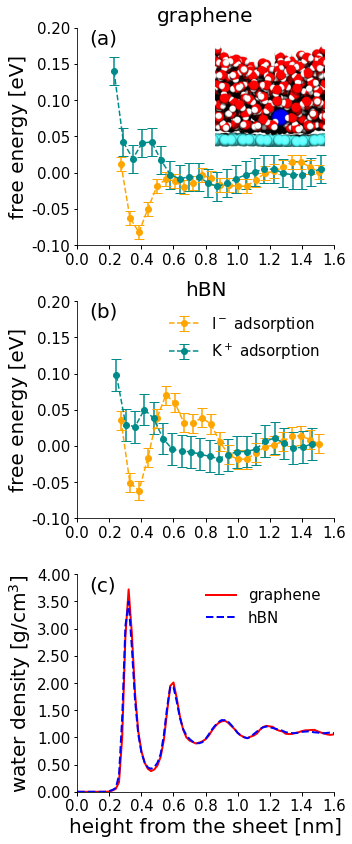

In [22]:

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(5,15))

xlims = (-0.0, 1.6)
ylims = (-0.1, 0.2)


titles = ['graphene','hBN']
xlabel = 'height from the sheet [nm]'
ylabel = 'free energy [eV]'
xticks = np.linspace(0,1.6,9)
xticklabels = np.linspace(0,1.6,9)


yticks = np.linspace(-.1,.2,7)
yticklabels = yticks


custom_lineplot(ax[0], height_GRAI, DG_GRAI*kjmol2eV, err_GRAI*kjmol2eV, xlims, ylims,color='orange',dlabel='')

custom_lineplot(ax[0], height_GRAK, DG_GRAK*kjmol2eV, err_GRAK*kjmol2eV, xlims, ylims,color='darkcyan',dlabel='')

stylize_axes(ax[0],titles[0],'',ylabel,xticks,yticks,xticklabels,yticklabels,floaty=2)

custom_lineplot(ax[1], height_BNI, DG_BNI*kjmol2eV, err_BNI*kjmol2eV, xlims, ylims,color='orange',dlabel='I$^-$ adsorption')

custom_lineplot(ax[1], height_BNK, DG_BNK*kjmol2eV, err_BNK*kjmol2eV, xlims, ylims,color='darkcyan',dlabel='K$^+$ adsorption')

stylize_axes(ax[1],titles[1],'',ylabel,xticks,yticks,xticklabels,yticklabels,floaty=2)


yticks = np.linspace(.0,4.0,9)
yticklabels = yticks

xlims = (-0.0, 1.6)
ylims = (-0., 4)
xlabel = 'height from the sheet [nm]'
ylabel = 'water density [g/cm$^3$]'


custom_line_only(ax[2],dens_gra[:,0],dens_gra[:,1], xlims, ylims,color='red',dlabel='graphene')

custom_line_only(ax[2],dens_hBN[:,0],dens_hBN[:,1], xlims, ylims,color='blue',dlabel='hBN',linestyle='--')

stylize_axes(ax[2],'',xlabel,ylabel,xticks,yticks,xticklabels,yticklabels,floaty=2)


ax[0].yaxis.label.set_size(20)
ax[0].xaxis.label.set_size(20)
ax[1].yaxis.label.set_size(20)
ax[1].xaxis.label.set_size(20)
ax[0].title.set_size(20)
ax[1].title.set_size(20)
ax[2].yaxis.label.set_size(20)
ax[2].xaxis.label.set_size(20)


for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(15)

for tick in ax[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(15)
    
for tick in ax[2].xaxis.get_major_ticks():
    tick.label.set_fontsize(15)
for tick in ax[2].yaxis.get_major_ticks():
    tick.label.set_fontsize(15)


ax[1].legend(prop={'size':15}, frameon = False)
ax[0].legend(prop={'size':15}, frameon = False)
ax[2].legend(prop={'size':15}, frameon = False)

img = mpimg.imread(dir_data+'/vmdscene.tga')

ip = InsetPosition(ax[0], [0.5,0.45,0.5,0.5])
ax[3].set_axes_locator(ip)

ax[3].imshow(img[ 60:460,12+40:500-45] )
ax[3].set_frame_on(False)
ax[3].get_xaxis().set_visible(False)
ax[3].get_yaxis().set_visible(False)


fig.text(0.1, 0.95,'(a)',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax[0].transAxes,
    fontsize=20)

fig.text(0.1, 0.95,'(b)',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax[1].transAxes,
    fontsize=20)


fig.text(0.1, 0.95,'(c)',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax[2].transAxes,
    fontsize=20)

fig.tight_layout()

fig.savefig(dir_figures+'/free_energy_vs_height.png', dpi=300, bbox_inches='tight', transparent=True)


### Make Fig.3

/Users/gabrieletocci/Software/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:170: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


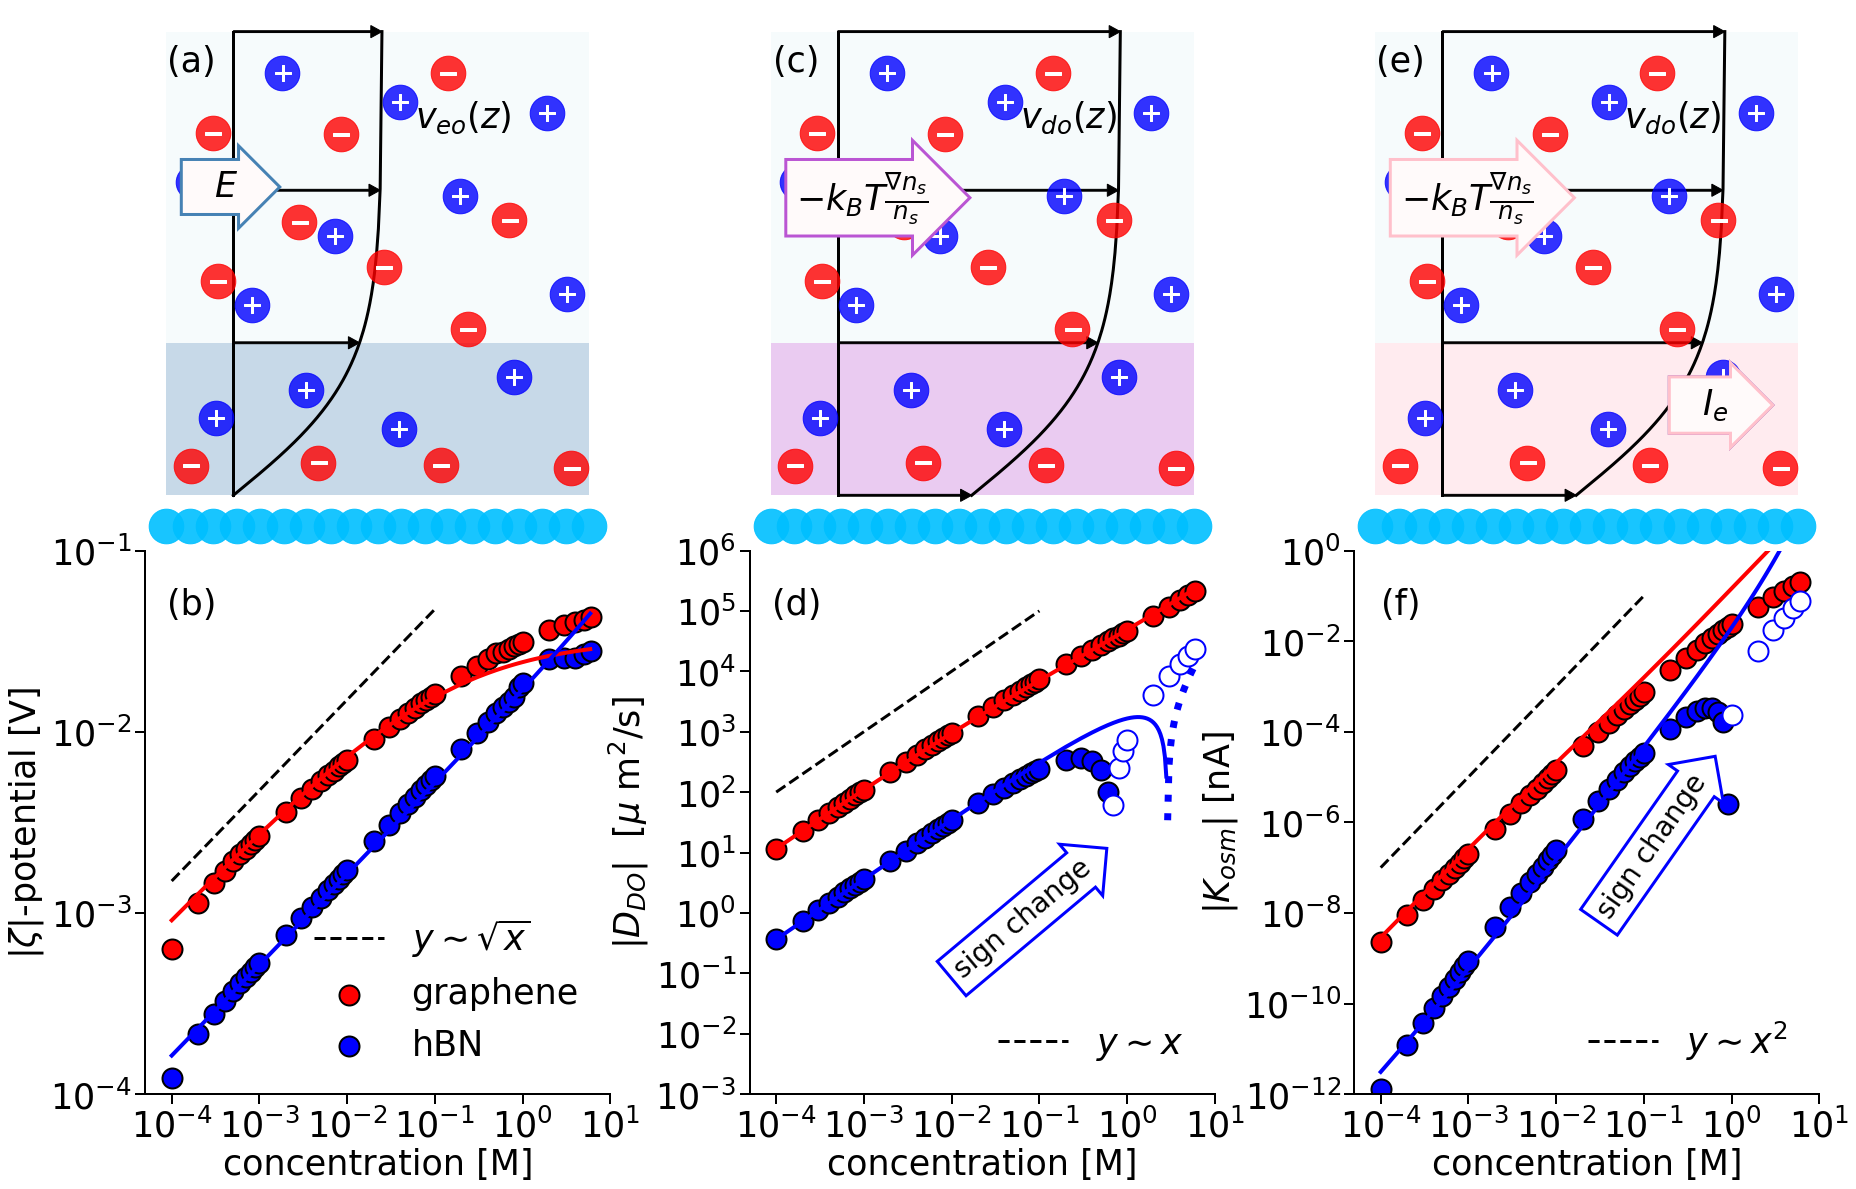

In [23]:


fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30,20))

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=-0.0)

scale_fact = 3.
slope=3.
x0=[0.0,0.3,0.3]
flow_col = "black"

colvec=["steelblue","mediumorchid","pink"]

# place a text box in upper left in axes coords

textstr_forces = [r"  $E$  ",r"$-k_BT\frac{\nabla n_s}{n_s}$",r"$-k_BT\frac{\nabla n_s}{n_s}$"]
textstr_fluxes = [r"$v_{eo}(z)$",r"$v_{do}(z)$",r"$v_{do}(z)$"]
props_fluxes = dict(facecolor='none', edgecolor='none')


for idx in range(3):

    props = dict(boxstyle="rarrow", fc="snow", ec=colvec[idx], lw=3,alpha=1)

    ax[0,idx].text(0.1, 0.7, textstr_forces[idx], transform=ax[0,idx].transAxes, fontsize=35,
        verticalalignment='top', bbox=props)
    
    ax[0,idx].text(0.7, 0.3, r'  $I_e$  ', transform=ax[0,2].transAxes, fontsize=35,
        verticalalignment='top', bbox=props)
    
    ax[0,idx].text(0.58, 0.83, textstr_fluxes[idx], transform=ax[0,idx].transAxes, fontsize=35,
        verticalalignment='top', bbox=props_fluxes)    
    
    ax[0,idx].scatter(rxp,ryp, s=scale_fact*400, facecolors='blue',edgecolors='blue',alpha=0.8,zorder=3)  
    ax[0,idx].scatter(rxp-0.002,ryp, s=scale_fact*120, marker='$+$',c='w',alpha=1.,zorder=3)
    ax[0,idx].scatter(rxm,rym, s=scale_fact*400, facecolors='red',edgecolors='red',alpha=0.8,zorder=3)  
    ax[0,idx].scatter(rxm-0.002,rym-0.03, s=scale_fact*120, marker='$-$',c='w',alpha=1,zorder=3)
    
    
    ax[0,idx].fill_between(xprime, y0, y1,color=colvec[idx],alpha=0.3,linewidth=0.0,zorder=1)
    ax[0,idx].fill_between(xprime, y1,y3,color='lightblue',alpha=0.1,linewidth=0.0,zorder=1)

    
    ax[0,idx].scatter(xprime, yprime, scale_fact*400, c="deepskyblue", alpha=0.9,zorder=2)
    ax[0,idx].plot(0.15+x+x0[idx], y0+np.arctanh(x*slope),c=flow_col,linewidth=scale_fact*1,zorder=2)
    ax[0,idx].plot(0.15+np.array([0.,0.]),np.array([y0+np.arctanh(x[0]*slope) ,(y0+np.arctanh(x[-1]*slope))]),c=flow_col,linewidth=scale_fact*1 ,zorder=2)

    if idx!=0:
        for q in [1,2,3,y2]:
            ax[0,idx].arrow(0.15,q* y0 +np.arctanh(x[0]*slope), np.tanh(q*y0 -y0)/slope +x0[idx] ,.0,
             fc=flow_col, ec=flow_col,width=scale_fact*0.005,head_width=0.1,head_length=0.025,length_includes_head=True,zorder=2 )
    else:
        for q in [2,3,y2]:
            ax[0,idx].arrow(0.15,q* y0 +np.arctanh(x[0]*slope), np.tanh(q*y0 -y0)/slope +x0[idx] ,.0,
             fc=flow_col, ec=flow_col,width=scale_fact*0.005,head_width=0.1,head_length=0.025,length_includes_head=True,zorder=2 )

        
    ax[0,idx].axis('off')


xlabel = 'concentration [M]'
xticks = np.linspace(0,1.6,9)
xticklabels = np.linspace(0,1.6,9)

yticks = np.linspace(.001,.1,11)
yticklabels = np.linspace(.001,.1,11)

xlims = (5*10**-5, 10)
ylims = (.0001, .1)

custom_line_only(ax[1,0],Conc[:28], 0.15*Conc[:28]**(0.5),xlims, ylims, color='black',dlabel='$y\sim \sqrt{x} $',linestyle='--',linewidth=3,legend_loc='upper left')
custom_scatterplot(ax[1,0], Conc,np.abs(Zeta_GRA) , 2., xlims, ylims, dlabel='graphene', color='red', markerscale=200,legend_loc='upper left')
custom_scatterplot(ax[1,0], Conc,np.abs(Zeta_BN) , 2., xlims, ylims, dlabel='hBN', color='blue', markerscale=200,legend_loc='upper left')
custom_line_only(ax[1,0],Conc_large, np.abs(zeta_Gra_esc),xlims, ylims, color='red',dlabel='',linestyle='-',linewidth=4,legend_loc='upper left')
custom_line_only(ax[1,0],Conc_large, np.abs(zeta_BN_esc),xlims, ylims, color='blue',dlabel='',linestyle='-',linewidth=4,legend_loc='upper left')

ax[1,0].set_xscale('log')
ax[1,0].set_yscale('log')
ylabel = '$|\zeta|$-potential [V]'

stylize_axes_default_ticks(ax[1,0],'',xlabel,ylabel)

xlims = (0.5*10**-4, 10)
ylims = (1e-3, 1e6)

yticks = np.linspace(-.1,.1,11)
yticklabels = np.linspace(-.1,.1,11)


custom_line_only(ax[1,1],Conc[:28], Conc[:28]*10**6,xlims, ylims, color='black',dlabel='$y\sim x $',linestyle='--',linewidth=3,legend_loc='lower right')
custom_scatterplot(ax[1,1], Conc,DDO_GRA , 2., xlims, ylims, dlabel='', color='red', markerscale=200)
custom_scatterplot(ax[1,1], Conc[:-9],np.abs(DDO_BN[:-9]), 2., xlims, ylims, dlabel='', color='blue', markerscale=200,legend_loc='lower right')
custom_scatterplot(ax[1,1], Conc[-9:],np.abs(DDO_BN[-9:]), 2., xlims, ylims, dlabel='', color='white',edgecolor='blue', markerscale=200,legend_loc='lower right')
custom_line_only(ax[1,1], Conc_large,np.abs(DDO_Gra_esc) ,xlims,ylims ,color='red', dlabel='', linestyle='-',linewidth=4,legend_loc='lower right')
custom_line_only(ax[1,1], Conc_large[:-31],np.abs(DDO_BN_esc[:-31]) ,xlims,ylims ,color='blue', dlabel='', linestyle='-',linewidth=4,legend_loc='lower right')
custom_line_only(ax[1,1], Conc_large[-31:],np.abs(DDO_BN_esc[-31:]) ,xlims,ylims ,color='blue', dlabel='', linestyle='dotted',linewidth=7,legend_loc='lower right')


ax[1,1].set_xscale('log')
ax[1,1].set_yscale('log')


t = ax[1,1].text(
    0.065, 0.8, "sign change", ha="center", va="center", rotation=40, size=28,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=3))

ylabel = '$|D_{DO}| $  [$\mu$ m$^2$/s]'
stylize_axes_default_ticks(ax[1,1],'',xlabel,ylabel)


xlims = (5*10**-5, 10)
ylims = (1e-12, 1)

custom_line_only(ax[1,2],Conc[:28], 10**1*Conc[:28]**2.0,xlims, ylims, color='black',dlabel='$y\sim x^2$',linestyle='--',linewidth=3,legend_loc='lower right')
custom_scatterplot(ax[1,2], Conc,np.abs( K_osm_GRA), 2., xlims, ylims, dlabel='', color='red', markerscale=200)
custom_scatterplot(ax[1,2], Conc[:-6], np.abs(K_osm_BN[:-6]) , 2., xlims, ylims, dlabel='', color='blue', markerscale=200,legend_loc="lower right")
custom_scatterplot(ax[1,2], Conc[-6:], np.abs(K_osm_BN[-6:]) , 2., xlims, ylims, dlabel='', color='white',edgecolor='blue', markerscale=200,legend_loc="lower right")

custom_line_only(ax[1,2], Conc_large,np.abs(K_osm_Gra_esc) ,xlims,ylims ,color='red', dlabel='', linestyle='-',linewidth=4,legend_loc='lower right')
custom_line_only(ax[1,2], Conc_large,np.abs(K_osm_BN_esc) ,xlims,ylims ,color='blue', dlabel='', linestyle='-',linewidth=4,legend_loc='lower right')


t = ax[1,2].text(
    0.125, 0.0000003, "sign change", ha="center", va="center", rotation=55, size=28,
    bbox=dict(boxstyle="rarrow,pad=0.3", fc="white", ec="blue", lw=3))

ax[1,2].set_xscale('log')
ax[1,2].set_yscale('log')


ylabel = '$|K_{osm}|$ [nA]'
stylize_axes_default_ticks(ax[1,2],'',xlabel,ylabel)

lab_size = 35
font_size = 35
      
                
figs_letts = [['(a)','(c)','(e)'],['(b)','(d)','(f)']]

for i in range(2):
    for j in range(3):

        fig.text(0.1, 0.9,figs_letts[i][j],
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax[i,j].transAxes,
             fontsize=font_size)

for q in range(3):

    ax[1,q].tick_params(width=2, length=10)
    ax[1,q].yaxis.set_minor_locator(ticker.NullLocator())
    ax[1,q].xaxis.set_minor_locator(ticker.NullLocator())
    ax[1,q].legend(prop={'size':font_size}, frameon = False,loc='lower right')
    for tick in ax[1,q].yaxis.get_majorticklabels():
        tick.set_horizontalalignment("right")  
        
    for tick in ax[1,q].xaxis.get_major_ticks():
        tick.label.set_fontsize(font_size)
    for tick in ax[1,q].yaxis.get_major_ticks():
        tick.label.set_fontsize(font_size)

    ax[1,q].yaxis.label.set_size(lab_size)
    ax[1,q].xaxis.label.set_size(lab_size)

for axis in ['bottom','left']:
  ax[1,0].spines[axis].set_linewidth(2)
  ax[1,1].spines[axis].set_linewidth(2)
  ax[1,2].spines[axis].set_linewidth(2)


fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)


fig.savefig(dir_figures+'/Transport_coefficients.png', dpi=300, bbox_inches='tight', transparent=True)

